In [ ]:
!pip -q install ultralytics opencv-python numpy tqdm

In [ ]:
!pip -q install ultralytics opencv-python numpy tqdm tensorflow

In [ ]:
import os
import math
from typing import List, Tuple, Optional

import cv2
import numpy as np
from tqdm import tqdm

try:
    from ultralytics import YOLO
except Exception as e:
    YOLO = None

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array

BOX = Tuple[int, int, int, int]
Point = Tuple[float, float]


def _center_of(box: BOX) -> Point:
    x1, y1, x2, y2 = box
    return ((x1 + x2) / 2.0, (y1 + y2) / 2.0)


def _euclidean(p1: Point, p2: Point) -> float:
    return math.hypot(p1[0] - p2[0], p1[1] - p2[1])


class SocialDistanceMaskMonitor:
    """
    Combines YOLOv8 person detection + mask classifier.
    Shows distancing violations and mask compliance.
    """

    def __init__(
        self,
        model_name: str = 'yolov8n.pt',
        conf: float = 0.25,
        distance_mode: str = 'pixel',
        pixel_thresh: float = 75.0,
        mask_model_path: str = None,
    ):
        if YOLO is None:
            raise RuntimeError("Ultralytics is not installed. Run `pip install ultralytics`." )
        self.model = YOLO(model_name)
        self.conf = conf
        self.distance_mode = distance_mode
        self.pixel_thresh = pixel_thresh
        self.mask_model = None
        if mask_model_path and os.path.exists(mask_model_path):
            self.mask_model = load_model(mask_model_path)

    def _detect_people(self, frame: np.ndarray) -> List[BOX]:
        results = self.model.predict(source=frame, imgsz=640, conf=self.conf, verbose=False)[0]
        boxes = []
        for b in results.boxes:
            if int(b.cls.item()) == 0:  # person
                x1, y1, x2, y2 = b.xyxy[0].tolist()
                boxes.append((int(x1), int(y1), int(x2), int(y2)))
        return boxes

    def _compute_violations(self, centers: List[Point]) -> List[Tuple[int, int]]:
        viol = []
        n = len(centers)
        for i in range(n):
            for j in range(i + 1, n):
                d = _euclidean(centers[i], centers[j])
                if d < self.pixel_thresh:
                    viol.append((i, j))
        return viol

    def _predict_mask(self, frame: np.ndarray, box: BOX) -> str:
        if self.mask_model is None:
            return "unknown"
        (x1, y1, x2, y2) = box
        face = frame[y1:y2, x1:x2]
        if face.size == 0:
            return "unknown"
        face = cv2.resize(face, (128, 128))
        face = face.astype("float") / 255.0
        face = img_to_array(face)
        face = np.expand_dims(face, axis=0)
        pred = self.mask_model.predict(face)[0]
        return "mask" if pred[0] > 0.5 else "no-mask"

    def annotate_frame(self, frame: np.ndarray) -> np.ndarray:
        boxes = self._detect_people(frame)
        centers = [_center_of(b) for b in boxes]
        viol_pairs = self._compute_violations(centers)

        # mark risky people
        risk = np.zeros(len(centers), dtype=bool)
        for (i, j) in viol_pairs:
            risk[i] = True
            risk[j] = True

        # draw link lines between violating pairs
        for (i, j) in viol_pairs:
            p1 = (int(centers[i][0]), int(centers[i][1]))
            p2 = (int(centers[j][0]), int(centers[j][1]))
            cv2.line(frame, p1, p2, (0, 0, 255), 2)  # red link

        # draw boxes + mask label
        masked_count = 0
        nomask_count = 0
        for idx, box in enumerate(boxes):
            (x1, y1, x2, y2) = box
            status = self._predict_mask(frame, box)  # "mask" / "no-mask" / "unknown"
            if status == "mask": masked_count += 1
            if status == "no-mask": nomask_count += 1

            color = (0, 0, 255) if risk[idx] else (0, 255, 0)  # red if violating else green
            cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
            cv2.putText(frame, status, (x1, max(0, y1 - 8)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

        # HUD (top-left)
        total = len(centers)
        safe = total - int(risk.sum())
        text = f"People: {total} | Safe: {safe} | Violations: {len(viol_pairs)} | Masked: {masked_count} | NoMask: {nomask_count}"
        cv2.rectangle(frame, (10, 10), (10 + 720, 40), (0, 0, 0), -1)
        cv2.putText(frame, text, (18, 34), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
        return frame


    def process_image(self, path: str, out_path: str = "output.jpg"):
        img = cv2.imread(path)
        annotated = self.annotate_frame(img)
        cv2.imwrite(out_path, annotated)
        from google.colab.patches import cv2_imshow
        cv2_imshow(annotated)

    def process_video(self, path: str, out_path: str = "output.mp4"):
        cap = cv2.VideoCapture(path)
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(out_path, fourcc, 20.0, (int(cap.get(3)), int(cap.get(4))))
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            annotated = self.annotate_frame(frame)
            out.write(annotated)
        cap.release()
        out.release()

    def process_webcam(self, cam_index: int = 0):
      cap = cv2.VideoCapture(cam_index)
      if not cap.isOpened():
          raise RuntimeError("Could not access webcam. In Colab, use the record_webcam() helper instead.")
      try:
          while True:
              ret, frame = cap.read()
              if not ret:
                  break
              annotated = self.annotate_frame(frame)
              cv2.imshow("Webcam - Press Q to quit", annotated)
              if cv2.waitKey(1) & 0xFF in (ord("q"), ord("Q")):
                  break
      finally:
          cap.release()
          cv2.destroyAllWindows()


In [ ]:
import cv2, numpy as np
from typing import Optional

class MaskClassifier:
    def __init__(self, mode: str = 'heuristic', keras_model_path: Optional[str] = None):
        self.mode = mode
        self.model = None
        if mode == 'keras':
            import tensorflow as tf
            if keras_model_path is None or not os.path.exists(keras_model_path):
                raise FileNotFoundError("Keras mode selected but mask_classifier.h5 not found.")
            self.model = tf.keras.models.load_model(keras_model_path)

    # --- Stronger skin detector (YCrCb range) ---
    @staticmethod
    def _skin_mask_bgr(bgr: np.ndarray) -> np.ndarray:
        ycrcb = cv2.cvtColor(bgr, cv2.COLOR_BGR2YCrCb)
        # Typical skin range in YCrCb
        lower = np.array([0, 133, 77], dtype=np.uint8)
        upper = np.array([255, 173, 127], dtype=np.uint8)
        mask = cv2.inRange(ycrcb, lower, upper)
        mask = cv2.medianBlur(mask, 5)
        return mask

    def predict(self, face_bgr: np.ndarray) -> float:
        """
        Return probability of MASK (1.0 masked, 0.0 no-mask).
        Heuristic: low skin in the lower-center face OR lots of mask-blue pixels.
        """
        if face_bgr is None or face_bgr.size == 0:
            return 0.0

        # If using a trained Keras model, prefer that
        if self.mode == 'keras' and self.model is not None:
            img = cv2.resize(face_bgr, (128, 128))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
            pred = self.model.predict(img[None, ...], verbose=0)[0]
            return float(pred[0]) if pred.shape[-1] == 2 else float(pred.squeeze())

        # ----- Heuristic path -----
        h, w = face_bgr.shape[:2]

        # Focus on lower CENTER (avoid cheeks/ears/background)
        y1 = h // 2
        y2 = h
        x1 = int(w * 0.20)
        x2 = int(w * 0.80)
        roi = face_bgr[y1:y2, x1:x2]
        if roi.size == 0:
            return 0.0

        # Skin ratio (YCrCb)
        skin = self._skin_mask_bgr(roi)
        skin_ratio = (skin > 0).mean()

        # Blue cloth ratio (HSV): many medical masks fall in this band
        hsv = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
        blue = cv2.inRange(hsv, (90, 40, 40), (130, 255, 255))
        blue_ratio = (blue > 0).mean()

        # Decision rule:
        # masked if little visible skin OR lots of blue cloth in lower center
        masked = (skin_ratio < 0.10) or (blue_ratio > 0.15)
        return 1.0 if masked else 0.0

In [ ]:
class SocialDistanceMonitorV2(SocialDistanceMaskMonitor):
    def __init__(self, *args, mask_classifier: Optional[MaskClassifier] = None,
                 mask_prob_thresh: float = 0.6, **kwargs):
        super().__init__(*args, **kwargs)
        self.mask_classifier = mask_classifier
        self.mask_prob_thresh = mask_prob_thresh

    def _predict_mask(self, frame: np.ndarray, box: BOX) -> str:
        # If a MaskClassifier is supplied, use it; else fall back to base .h5 model logic
        if self.mask_classifier is None:
            return super()._predict_mask(frame, box)

        x1, y1, x2, y2 = box
        face = frame[y1:y2, x1:x2]
        if face.size == 0:
            return "unknown"

        prob = self.mask_classifier.predict(face)  # returns prob of MASK
        return "mask" if prob >= self.mask_prob_thresh else "no-mask"

In [ ]:
from google.colab import output
from IPython.display import display, Javascript

def record_webcam(filename="webcam_clip.mp4", duration=5):
    js = Javascript(f"""
    async function recordVideo() {{
      const stream = await navigator.mediaDevices.getUserMedia({{video:true}});
      const recorder = new MediaRecorder(stream);
      let data = [];
      recorder.ondataavailable = e => data.push(e.data);
      recorder.start();
      await new Promise(r => setTimeout(r, {duration*1000}));
      recorder.stop();
      await new Promise(r => recorder.onstop = r);
      const blob = new Blob(data, {{type: 'video/webm'}});
      const buffer = await blob.arrayBuffer();
      const uint8 = new Uint8Array(buffer);
      google.colab.kernel.invokeFunction('notebook.saveVideo', [uint8, '{filename}'], {{}});
    }}
    recordVideo();
    """)
    display(js)

def save_video(uint8, filename):
    with open(filename, "wb") as f:
        f.write(bytearray(uint8))

output.register_callback("notebook.saveVideo", save_video)

In [ ]:
!pip -q install ultralytics opencv-python numpy tqdm tensorflow

#EG1 IMAGE MASK

In [ ]:
from google.colab import files
uploaded = files.upload()
for filename in uploaded.keys():
    print(f"Uploaded file: {filename}")

Saving Screenshot 2025-09-04 at 5.04.20 PM.png to Screenshot 2025-09-04 at 5.04.20 PM (1).png
Uploaded file: Screenshot 2025-09-04 at 5.04.20 PM (1).png


In [ ]:
import os
fn = next(iter(uploaded))                 # the actual uploaded name (handles spaces and (1).png)
src = f"/content/{fn}"
root, ext = os.path.splitext(fn)
dst = f"/content/input{ext.lower()}"      # standardize the name

# overwrite if it already exists
if os.path.exists(dst):
    os.remove(dst)
os.rename(src, dst)

print("Saved as:", dst)

Saved as: /content/input.png


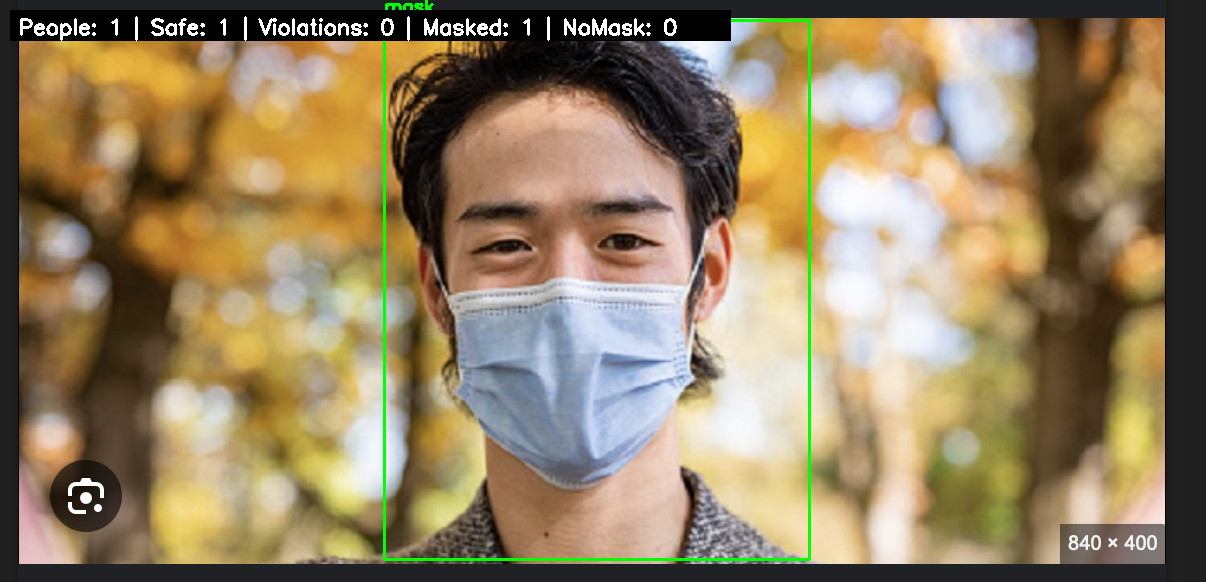

In [ ]:
# Run detection
mask_cls = MaskClassifier(mode='heuristic')
monitor = SocialDistanceMonitorV2(
    model_name='yolov8n.pt',
    pixel_thresh=75.0,
    mask_classifier=mask_cls,
    mask_prob_thresh=0.5   # slightly lower since heuristic returns 0/1
)
monitor.process_image(dst, out_path="annotated.jpg")

#EG2 IMAGE UNMASK

In [ ]:
from google.colab import files
uploaded = files.upload()
for filename in uploaded.keys():
    print(f"Uploaded file: {filename}")

Saving Screenshot 2025-09-04 at 5.20.36 PM.png to Screenshot 2025-09-04 at 5.20.36 PM.png
Uploaded file: Screenshot 2025-09-04 at 5.20.36 PM.png


In [ ]:
import os
fn = next(iter(uploaded))                 # the actual uploaded name (handles spaces and (1).png)
src = f"/content/{fn}"
root, ext = os.path.splitext(fn)
dst = f"/content/input{ext.lower()}"      # standardize the name

# overwrite if it already exists
if os.path.exists(dst):
    os.remove(dst)
os.rename(src, dst)

print("Saved as:", dst)

Saved as: /content/input.png


Using: /content/input.png


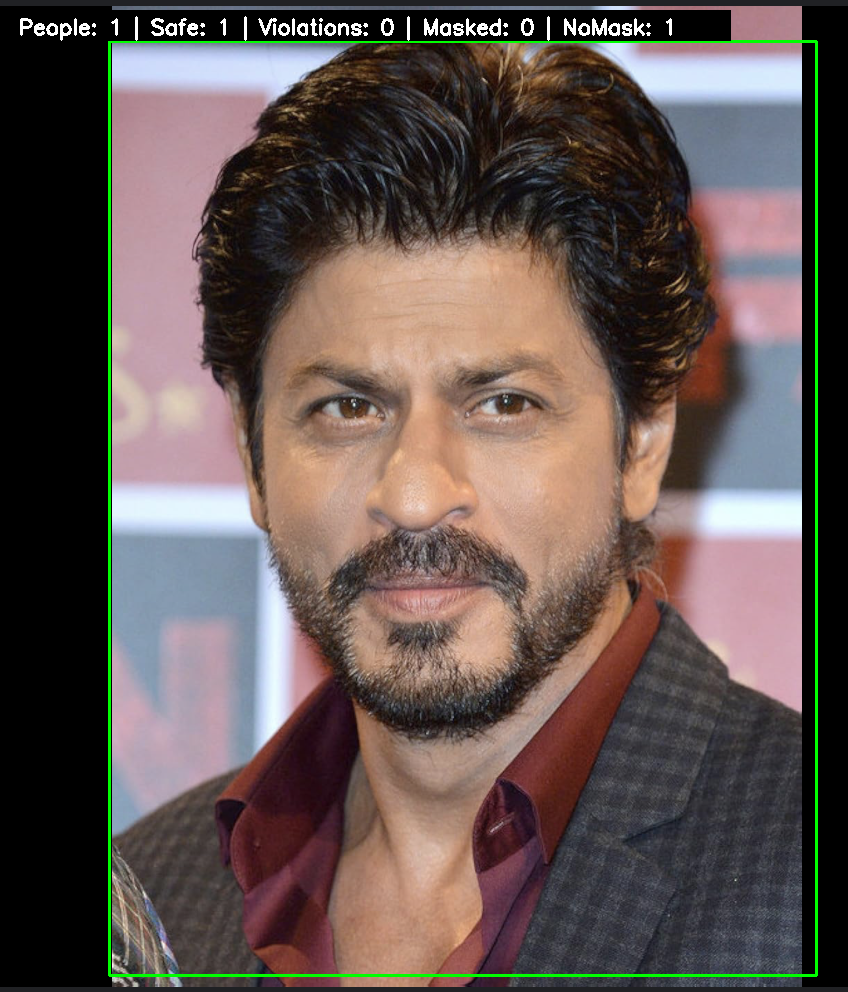

In [ ]:
# 1) Make sure THIS is the only V2 class you have loaded
#    (comment out/delete the shorter V2 that only overrides _predict_mask)

# 2) Attach a mask classifier and run detection
mask_cls = MaskClassifier(mode='heuristic')  # or: MaskClassifier(mode='keras', keras_model_path='/content/mask_classifier.h5')

monitor = SocialDistanceMonitorV2(
    model_name='yolov8n.pt',
    conf=0.25,
    pixel_thresh=140,        # keep high for crowd photos; tune 120–200
    mask_classifier=mask_cls,
    mask_prob_thresh=0.55    # tweak: 0.45–0.65 depending on your images
)

# Use the standardized upload from earlier
import glob, cv2
img_path = sorted(glob.glob('/content/input.*'))[0]
print("Using:", img_path)

monitor.process_image(img_path, out_path="annotated.jpg")

#EG3

In [ ]:
from google.colab import files
uploaded = files.upload()
for filename in uploaded.keys():
    print(f"Uploaded file: {filename}")

Saving Screenshot 2025-09-04 at 5.24.24 PM.png to Screenshot 2025-09-04 at 5.24.24 PM.png
Uploaded file: Screenshot 2025-09-04 at 5.24.24 PM.png


In [ ]:
import os
fn = next(iter(uploaded))                 # the actual uploaded name (handles spaces and (1).png)
src = f"/content/{fn}"
root, ext = os.path.splitext(fn)
dst = f"/content/input{ext.lower()}"      # standardize the name

# overwrite if it already exists
if os.path.exists(dst):
    os.remove(dst)
os.rename(src, dst)

print("Saved as:", dst)

Saved as: /content/input.png


Using: /content/input.png


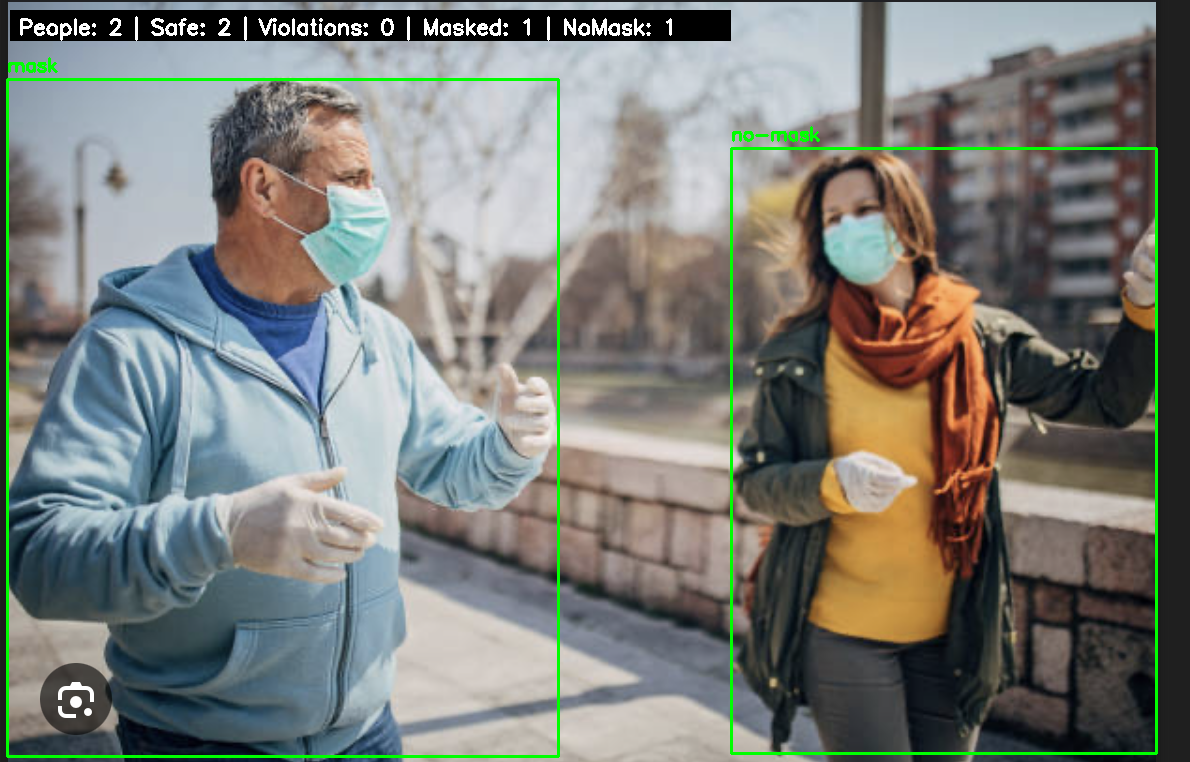

In [ ]:
# 1) Make sure THIS is the only V2 class you have loaded
#    (comment out/delete the shorter V2 that only overrides _predict_mask)

# 2) Attach a mask classifier and run detection
mask_cls = MaskClassifier(mode='heuristic')  # or: MaskClassifier(mode='keras', keras_model_path='/content/mask_classifier.h5')

monitor = SocialDistanceMonitorV2(
    model_name='yolov8n.pt',
    conf=0.25,
    pixel_thresh=140,        # keep high for crowd photos; tune 120–200
    mask_classifier=mask_cls,
    mask_prob_thresh=0.55    # tweak: 0.45–0.65 depending on your images
)

# Use the standardized upload from earlier
import glob, cv2
img_path = sorted(glob.glob('/content/input.*'))[0]
print("Using:", img_path)

monitor.process_image(img_path, out_path="annotated.jpg")


#EG4

In [ ]:
from google.colab import files
uploaded = files.upload()
for filename in uploaded.keys():
    print(f"Uploaded file: {filename}")

Saving Screenshot 2025-09-04 at 5.26.37 PM.png to Screenshot 2025-09-04 at 5.26.37 PM.png
Uploaded file: Screenshot 2025-09-04 at 5.26.37 PM.png


In [ ]:
import os
fn = next(iter(uploaded))                 # the actual uploaded name (handles spaces and (1).png)
src = f"/content/{fn}"
root, ext = os.path.splitext(fn)
dst = f"/content/input{ext.lower()}"      # standardize the name

# overwrite if it already exists
if os.path.exists(dst):
    os.remove(dst)
os.rename(src, dst)

print("Saved as:", dst)

Saved as: /content/input.png


Using: /content/input.png


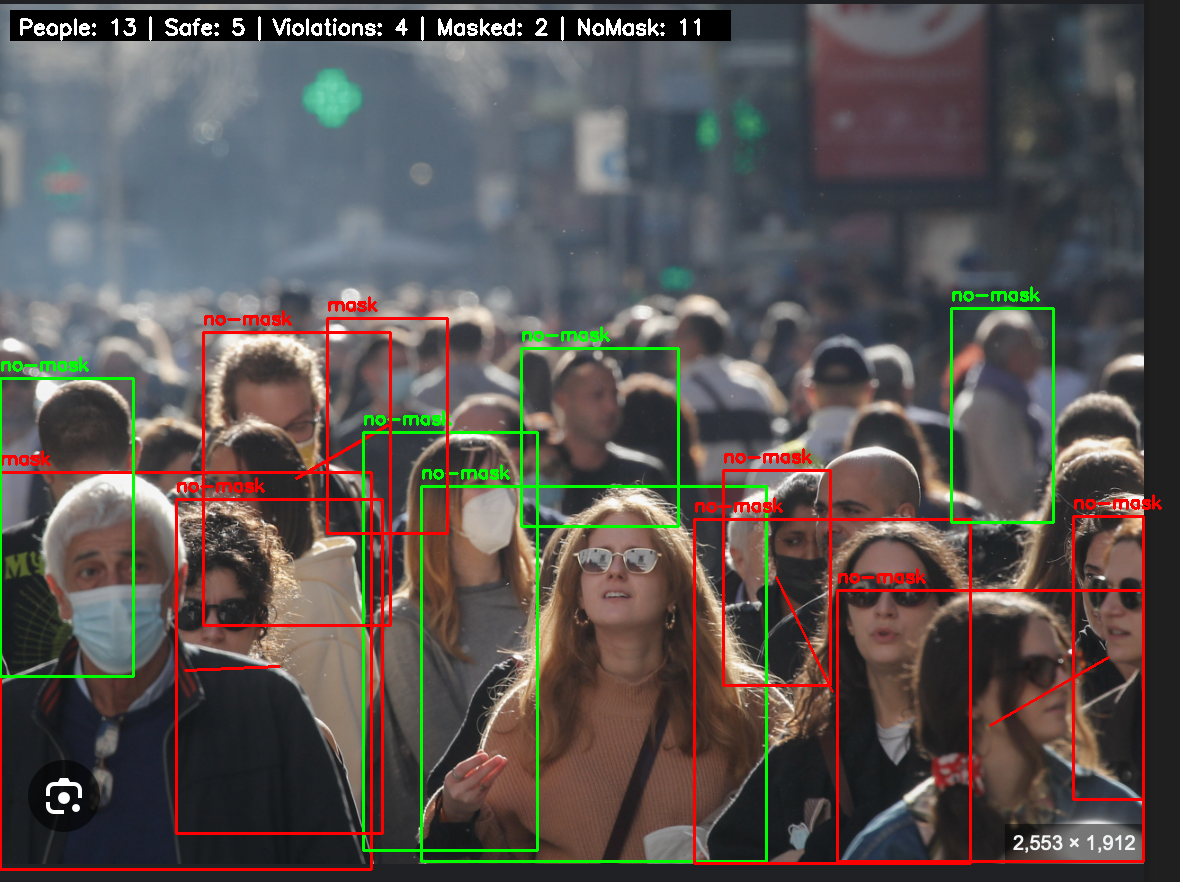

In [ ]:
# 1) Make sure THIS is the only V2 class you have loaded
#    (comment out/delete the shorter V2 that only overrides _predict_mask)

# 2) Attach a mask classifier and run detection
mask_cls = MaskClassifier(mode='heuristic')  # or: MaskClassifier(mode='keras', keras_model_path='/content/mask_classifier.h5')

monitor = SocialDistanceMonitorV2(
    model_name='yolov8n.pt',
    conf=0.25,
    pixel_thresh=140,        # keep high for crowd photos; tune 120–200
    mask_classifier=mask_cls,
    mask_prob_thresh=0.55    # tweak: 0.45–0.65 depending on your images
)

# Use the standardized upload from earlier
import glob, cv2
img_path = sorted(glob.glob('/content/input.*'))[0]
print("Using:", img_path)

monitor.process_image(img_path, out_path="annotated.jpg")


#WebCam (use webcam on google chrome / edge not on safari) and can see the output in safari

In [ ]:
# Cell A — record from your webcam (works in Chrome/Edge)
from google.colab import output
from IPython.display import Javascript, display

def _save_video(uint8, filename):
    with open(filename, "wb") as f:
        f.write(bytearray(uint8))
    print("Saved:", filename)

output.register_callback("notebook.saveVideo", _save_video)

def record_webcam(filename="webcam_clip.webm", duration=8):
    display(Javascript(f"""
    (async () => {{
      const div = document.createElement('div');
      const p   = document.createElement('p');
      p.textContent = 'Recording {duration} s… (preview below)';
      const video = document.createElement('video');
      video.style.width = '480px';
      video.autoplay = true; video.muted = true; video.playsInline = true;
      div.appendChild(p); div.appendChild(video); document.body.appendChild(div);

      const stream = await navigator.mediaDevices.getUserMedia({{video:true, audio:false}});
      video.srcObject = stream;

      const rec = new MediaRecorder(stream, {{mimeType:'video/webm'}});
      let chunks = [];
      rec.ondataavailable = e => chunks.push(e.data);
      rec.start();

      await new Promise(r => setTimeout(r, {duration*1000}));
      await new Promise(r => (rec.onstop = r, rec.stop()));
      stream.getVideoTracks()[0].stop();

      const blob = new Blob(chunks, {{type:'video/webm'}});
      const buf = new Uint8Array(await blob.arrayBuffer());
      google.colab.kernel.invokeFunction('notebook.saveVideo', [Array.from(buf), '{filename}'], {{}});
    }})()
    """))

# ▶️ Run this:
record_webcam("webcam_clip.webm", duration=8)

<IPython.core.display.Javascript object>

Saved: webcam_clip.webm


In [ ]:
# Convert to mp4 and run your pipeline
!ffmpeg -y -loglevel error -i webcam_clip.webm -vcodec libx264 -pix_fmt yuv420p webcam_clip.mp4

# Example: use your monitor on the clip
mask_cls = MaskClassifier(mode='heuristic')  # or 'keras' with your .h5
monitor = SocialDistanceMaskMonitor(model_name='yolov8n.pt', pixel_thresh=140)
# If you want mask+distance using V2 with heuristic:
# monitor = SocialDistanceMonitorV2(model_name='yolov8n.pt', pixel_thresh=140, mask_classifier=mask_cls)

monitor.process_video("webcam_clip.mp4", out_path="webcam_annotated.mp4")

# Inline preview
from IPython.display import HTML
from base64 import b64encode
data_url = "data:video/mp4;base64," + b64encode(open("webcam_annotated.mp4","rb").read()).decode()
HTML(f'<video controls width="800" src="{data_url}"></video>')


#Video

In [ ]:
from google.colab import files
uploaded = files.upload()
for filename in uploaded.keys():
    print(f"Uploaded file: {filename}")

Saving HappyRobot.mov to HappyRobot.mov
Uploaded file: HappyRobot.mov


In [ ]:
import cv2
cap = cv2.VideoCapture("/content/HappyRobot.mov")
ret, first = cap.read(); cap.release()
assert ret, "Could not read first frame."
px_thresh = int(0.15 * first.shape[1])   # e.g., 15% of width
print("pixel_thresh =", px_thresh, "| frame size =", first.shape[1], "x", first.shape[0])

pixel_thresh = 162 | frame size = 1080 x 1920


In [ ]:
# Heuristic (no extra model needed) — labels "mask" / "no-mask"
mask_cls = MaskClassifier(mode='heuristic')     # or mode='keras', keras_model_path='/content/mask_classifier.h5'

monitor = SocialDistanceMonitorV2(
    model_name='yolov8n.pt',
    conf=0.35,
    pixel_thresh=px_thresh,
    mask_classifier=mask_cls,
    mask_prob_thresh=0.6
)
monitor.process_video("/content/HappyRobot.mov", out_path="/content/annotated.mp4")

In [ ]:
from IPython.display import HTML
from base64 import b64encode
data_url = "data:video/mp4;base64," + b64encode(open("/content/annotated.mp4","rb").read()).decode()
HTML(f'<video controls width="800" src="{data_url}"></video>')

Buffered data was truncated after reaching the output size limit.